网点现金预测建模 Baseline
数据样本背景：佛山三水一住宅区附近网点，整体交易量在网点中属于中下水平
样本数据集：20180101-2020-05-31
验证数据集：20200602

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.api import tsa
import time
from matplotlib import font_manager as fm, rcParams
from chinese_calendar import is_workday, is_holiday
import calendar
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置
%matplotlib inline

In [2]:
#读取数据，数据
tmp_df = pd.read_csv('./iml_txn_dpst_fin_dtl_e_casestudy.csv')

tmp_df['date'] = pd.to_datetime(tmp_df['pass_acct_dt'], format='%Y%m%d')
tmp_df = tmp_df.loc[tmp_df['prest_txn_tm']!=0]
tmp_df = tmp_df.loc[tmp_df['txn_amt']>=-50000]
tmp_df.set_index('date', inplace=True)
tmp_df = tmp_df[['prest_txn_tm','txn_amt']]
tmp_df.head()

,prest_txn_tm,txn_amt
date,,
2019-07-13,10514868,150.0
2019-07-13,10320728,50.0
2019-07-13,11202778,50.0
2019-07-13,11202875,225.0
2019-07-13,15475186,80.0


In [3]:
tmp_df = tmp_df.sort_values(by=['date','prest_txn_tm'])
tmp_group = tmp_df.groupby('date')
tmp_group = tmp_group.cumsum()
daily_cash_req = tmp_group.groupby('date').min()
daily_cash_req = daily_cash_req.rename(columns={'txn_amt':'cash_req'})
daily_cash_req.head(5)

,prest_txn_tm,cash_req
date,,
2018-01-01,3151059,-34188.0
2018-01-02,501102,-70600.0
2018-01-03,1392638,-1700.0
2018-01-04,554975,-36100.0
2018-01-05,1572877,1300.0


In [4]:
is_holi = []
for i in daily_cash_req.index:
    is_holi.append(is_holiday(i))
daily_cash_req['is_holi'] = is_holi
daily_cash_req

,prest_txn_tm,cash_req,is_holi
date,,,
2018-01-01,3151059,-34188.00,True
2018-01-02,501102,-70600.00,False
2018-01-03,1392638,-1700.00,False
2018-01-04,554975,-36100.00,False
2018-01-05,1572877,1300.00,False
...,...,...,...
2020-08-16,133665,-28680.73,True
2020-08-17,483137,-41971.77,False
2020-08-18,391095,-500.20,False


In [5]:
daily_cash_req.loc[daily_cash_req['is_holi']==True].describe()

,prest_txn_tm,cash_req
count,3.050000e+02,305.000000
mean,1.262173e+06,-60689.607869
std,1.687364e+06,56620.690340
min,8.990000e+02,-295255.000000
25%,2.309470e+05,-87101.000000
50%,4.049580e+05,-44400.000000
75%,1.563503e+06,-17400.000000
max,8.070056e+06,9800.000000


In [78]:
daily_cash_req.loc[~daily_cash_req['is_holi']==True].describe()

,prest_txn_tm,cash_req
count,6.580000e+02,658.000000
mean,1.048312e+06,-52871.132112
std,1.407311e+06,60673.921227
min,2.880000e+02,-426558.000000
25%,2.441732e+05,-75005.995000
50%,4.232125e+05,-36999.020000
75%,1.249858e+06,-12000.000000
max,9.405401e+06,195154.690000


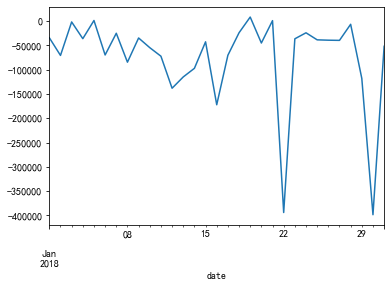

In [14]:
daily_cash_req['cash_req']['20180101':'20180131'].plot()

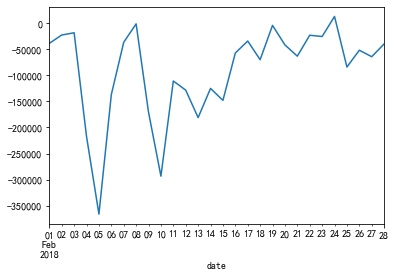

In [15]:
daily_cash_req['cash_req']['20180201':'20180228'].plot()

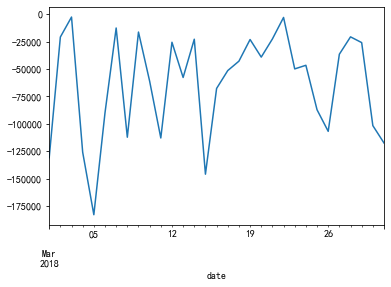

In [16]:
daily_cash_req['cash_req']['20180301':'20180331'].plot()

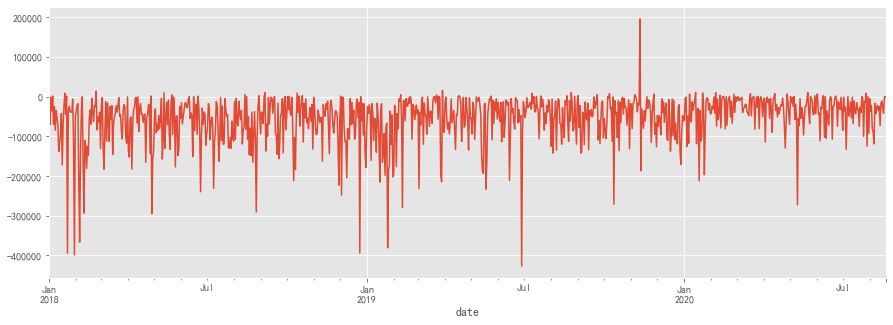

In [4]:
plt.style.use('ggplot')
fig = plt.subplots(figsize=(15,5))
daily_cash_req['cash_req'].plot()

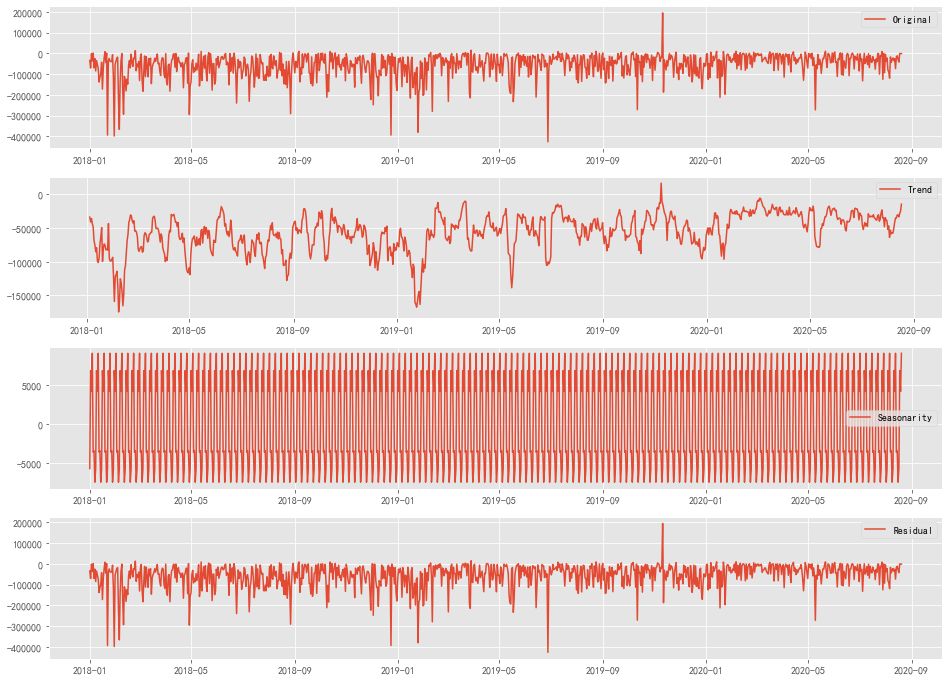

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(16,12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(timeseries, label='Residual')
    plt.legend(loc='best')
    plt.show()
    
    return trend.fillna(0), seasonal.fillna(0), residual.fillna(0)

cash_req_t, cash_req_s, cash_req_r = decomposing(daily_cash_req['cash_req'])

In [10]:
train_seq_t = cash_req_t['20180101':'20200531']
val_seq_t = cash_req_t['20200601':'20200820']
train_seq_s = cash_req_s['20180101':'20200531']
val_seq_s = cash_req_s['20200601':'20200820']
train_seq_r = cash_req_r['20180101':'20200531']
val_seq_r = cash_req_r['20200601':'20200820']

In [17]:
print(tsa.stattools.adfuller(train_seq_t.diff(1).fillna(0)))

(-11.142701101795584, 3.079887611136673e-20, 20, 861, {'1%': -3.4379677736185514, '5%': -2.8649026847264074, '10%': -2.568560548763626}, 18157.518059041162)


In [12]:
print(tsa.stattools.adfuller(cash_req_r))

(-13.459435090105755, 3.5538200109696026e-25, 21, 941, {'1%': -3.4373183615045266, '5%': -2.864616349295443, '10%': -2.568408028822753}, 22521.482764937522)


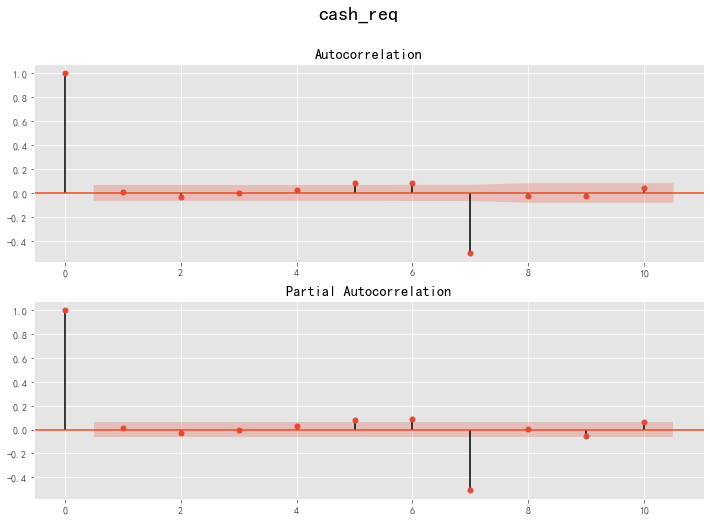

In [30]:
import statsmodels.api as sm

def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(12, 8))
    plt.suptitle(timeseries.name, fontsize=20)
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()

autocorrelation(train_seq_t.diff(1).fillna(0), 10)


In [20]:
#AIC BIC
import statsmodels.api as sm
import time
start = time.time()
train_seq_diff_evaluate = sm.tsa.arma_order_select_ic(train_seq_t.diff(1).fillna(0),
                                                      ic=['aic', 'bic'], trend='nc', max_ar=8, max_ma=8)
print('trend AIC', train_seq_diff_evaluate.aic_min_order)
print('trend BIC', train_seq_diff_evaluate.bic_min_order)
end = time.time()
print(end-start)

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianI

trend AIC (3, 8)
trend BIC (0, 7)
789.8403577804565


C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [88]:
train_t.fillna(0)

date
2018-01-01       0.000000
2018-01-02       0.000000
2018-01-03       0.000000
2018-01-04    1316.857143
2018-01-05   -7189.785714
                 ...     
2020-05-27    6008.841429
2020-05-28    3578.665714
2020-05-29       0.000000
2020-05-30       0.000000
2020-05-31       0.000000
Name: cash_req, Length: 882, dtype: float64

In [42]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit(disp=0)

start = time.time()

trend_model = ARIMA_Model(train_seq_t, (0,1,7))
trend_fit_seq = trend_model.fittedvalues

end = time.time()
print(end-start)

C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


15.669878959655762


C:\Users\TerryCai\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


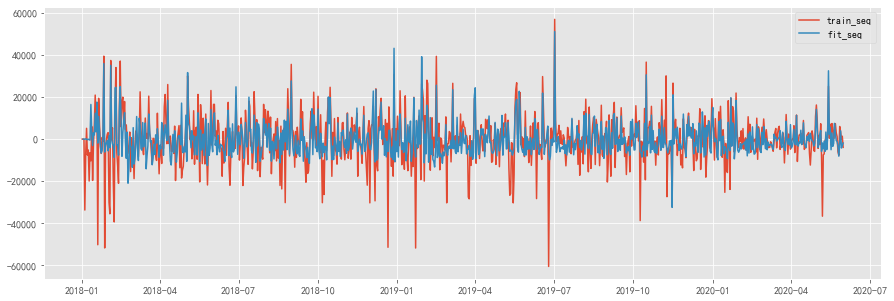

In [43]:
fig = plt.subplots(figsize=(15,5))
cash_req_t_diff = cash_req_t.diff(1).fillna(0)
plt.plot(cash_req_t_diff[:'20200531'], label='train_seq')
plt.plot(loc='best')
plt.plot(trend_fit_seq, label='fit_seq')
plt.legend(loc='best')
plt.show()

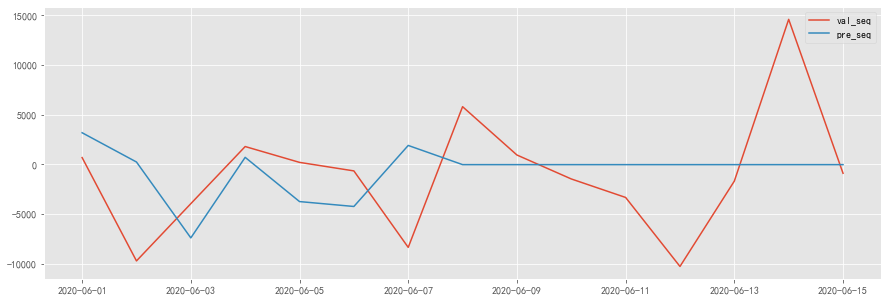

In [44]:
predict_seq = trend_model.predict(start='20200601',end='20200615', dynamic=True)
fig = plt.subplots(figsize=(15,5))
plt.plot(cash_req_t_diff['20200601':'20200615'], label='val_seq')
plt.plot(loc='best')
plt.plot(predict_seq, label='pre_seq')
plt.legend(loc='best')
plt.show()

In [45]:
def count_deposit_ratios(df, baseline):
    total = df.loc[df['txn_amt']>0].count()
    count = df.loc[df['txn_amt']>baseline].count()
    percentage = count/total
    print('total:{}, count:{}, percentage:{}'.format(total, count, percentage))
    return percentage
count_deposit_ratios(train_seq, 500000)


NameError: name 'train_seq' is not defined

In [37]:
import winsound
duration = 1000  # millisecond
freq = 600  # Hz
winsound.Beep(freq, duration)